In [1]:
import os
import gc
from glob import glob
import openslide
from tqdm.notebook import tqdm
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np
import xml.etree.ElementTree as ET
import warnings
from PIL import Image
# import libtiff

warnings.filterwarnings(action='ignore')
Image.MAX_IMAGE_PIXELS = None
# libtiff.libtiff_ctypes.suppress_warnings()

In [2]:
LEVEL = 5
MAGNIFICATION = 1.25
PATCH_SIZE = (512, 512) # width, height
OVERLAP_RATIO = 0.2
TISSUE_AREA_RATIO = 0.0 # normal case

def is_inside_tissue(_mask):
    tissue_area = np.sum(_mask) // 255
    mask_area = np.prod(PATCH_SIZE)
    return (tissue_area / mask_area) > TISSUE_AREA_RATIO

tissue_kernel_1 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
tissue_kernel_2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))

def get_otsu_mask(_img):
    _, _, v = cv2.split(cv2.cvtColor(_img, cv2.COLOR_RGB2YUV))
    v = cv2.medianBlur(v, 15)
    _, timg_th = cv2.threshold(v, -1, 255, cv2.THRESH_OTSU)
    timg_th = cv2.morphologyEx(timg_th, cv2.MORPH_OPEN, tissue_kernel_1, iterations=2)
    timg_th = cv2.morphologyEx(timg_th, cv2.MORPH_CLOSE, tissue_kernel_1, iterations=2)
    timg_th = cv2.morphologyEx(timg_th, cv2.MORPH_OPEN, tissue_kernel_1, iterations=5)
    timg_th = cv2.morphologyEx(timg_th, cv2.MORPH_CLOSE, tissue_kernel_1, iterations=5)
    return timg_th

In [3]:
tumor_list = glob('/workspace/data4/CAMELYON16/training/tumor/*.tif')

  0%|          | 0/10 [00:00<?, ?it/s]

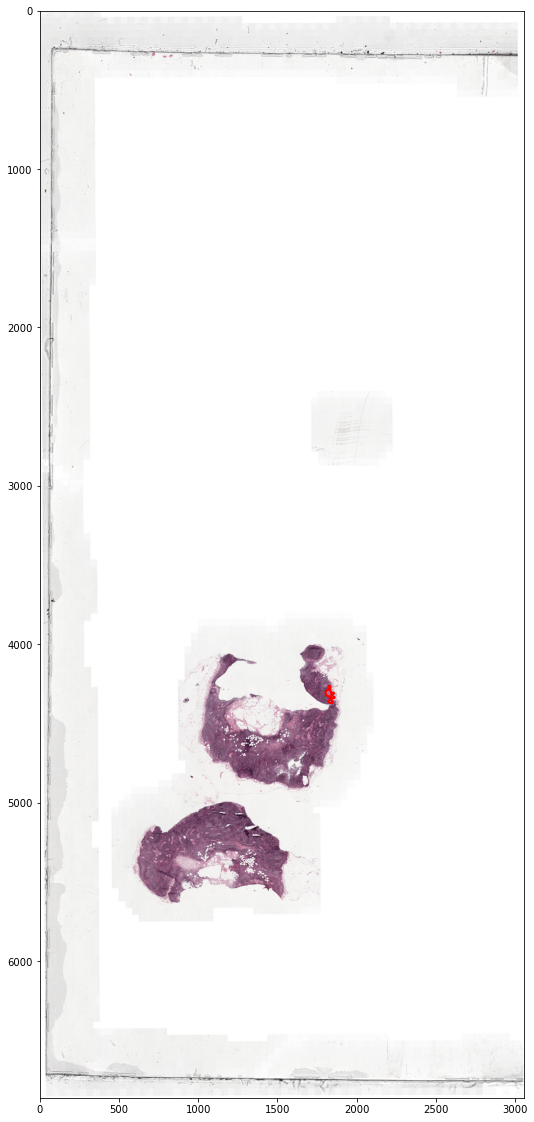

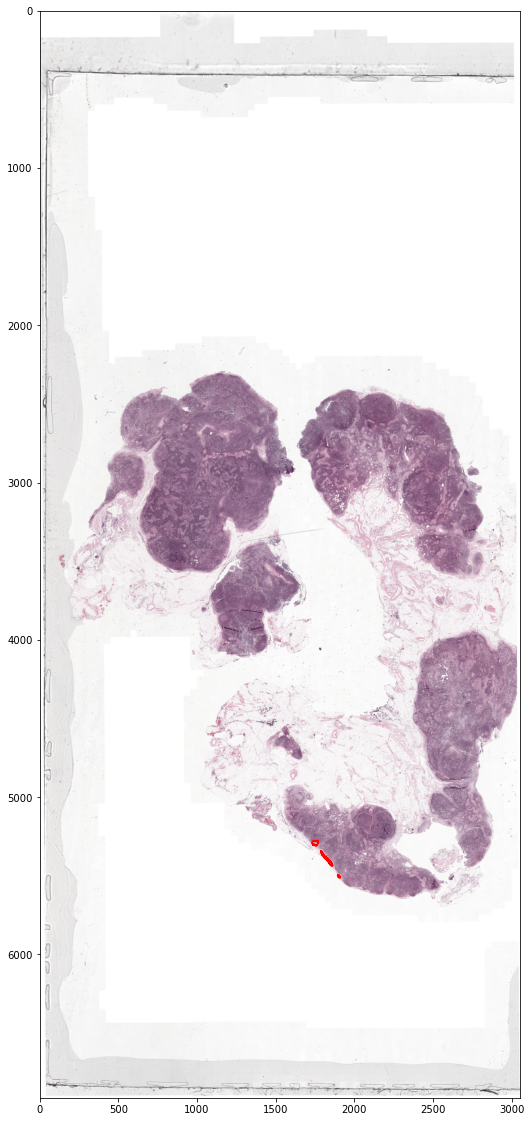

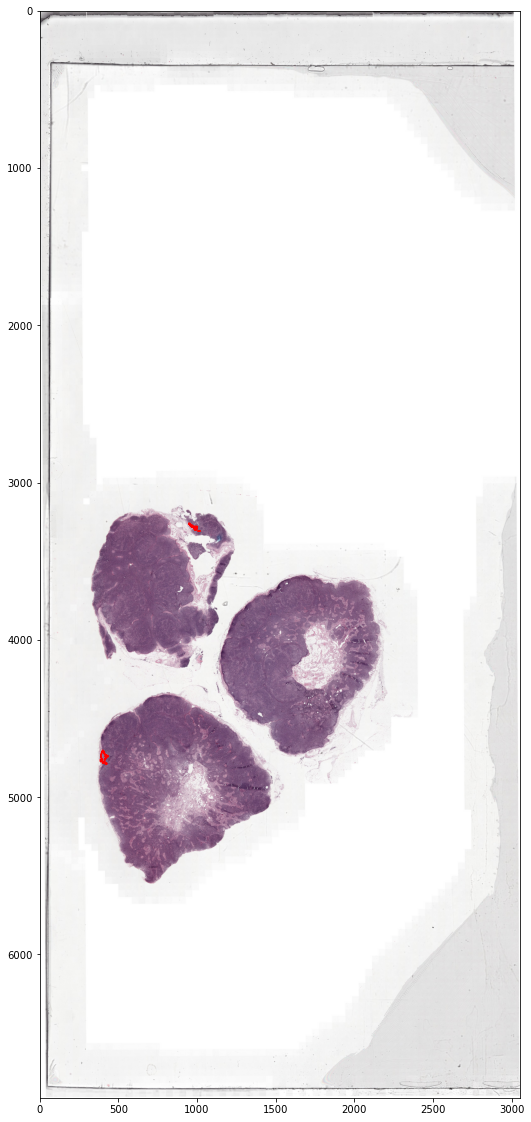

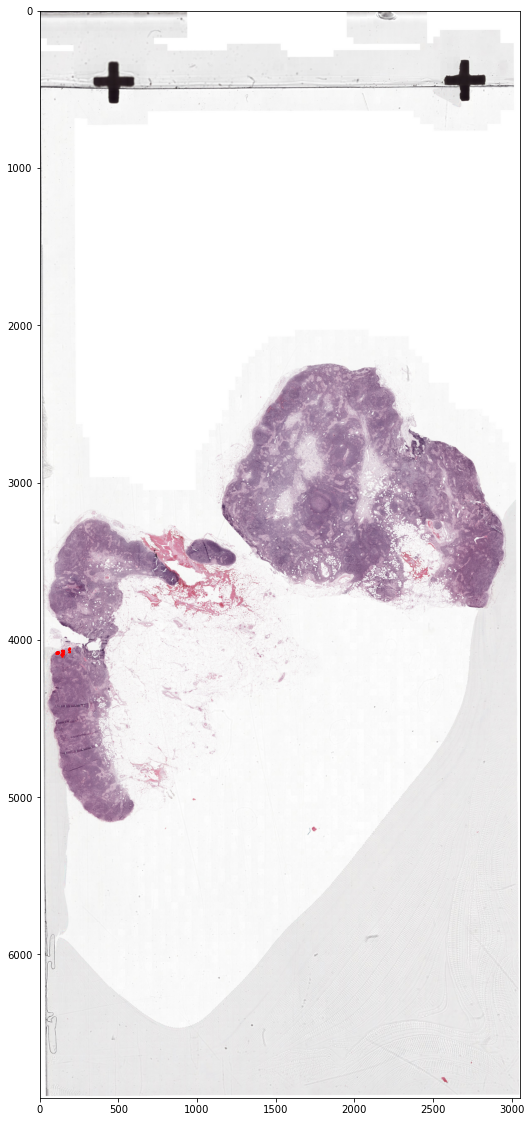

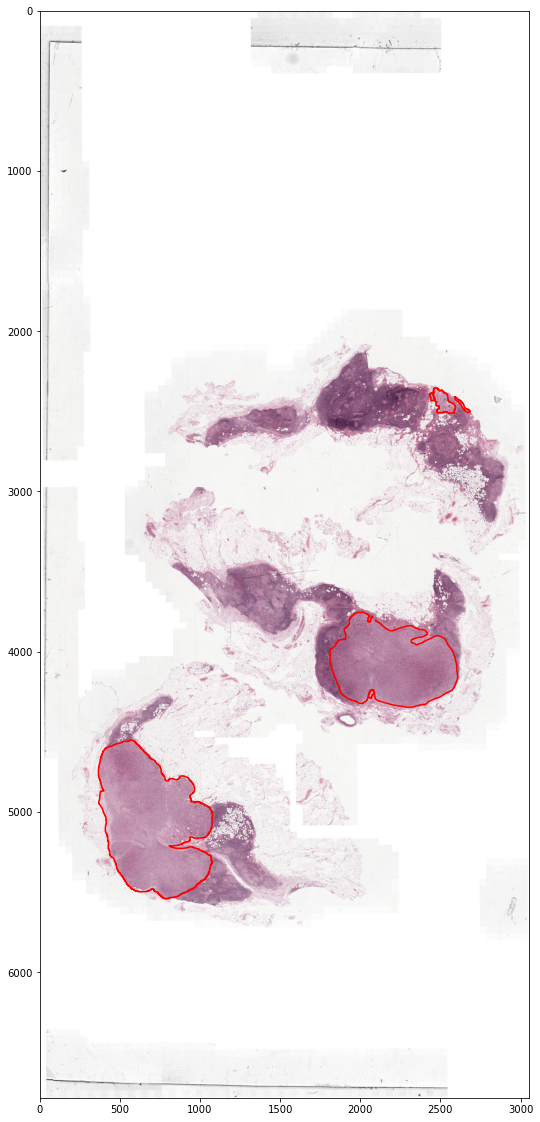

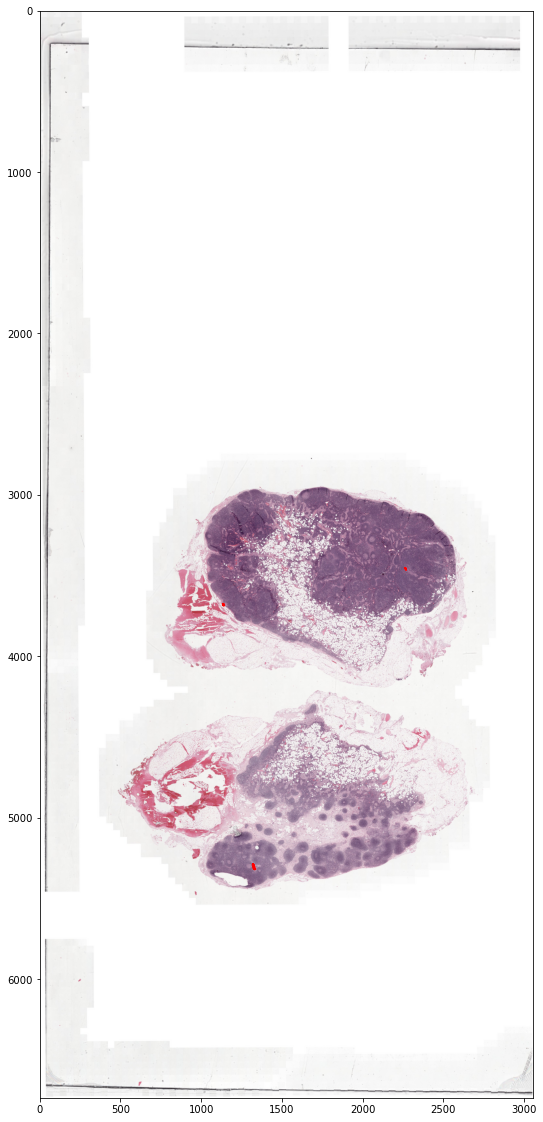

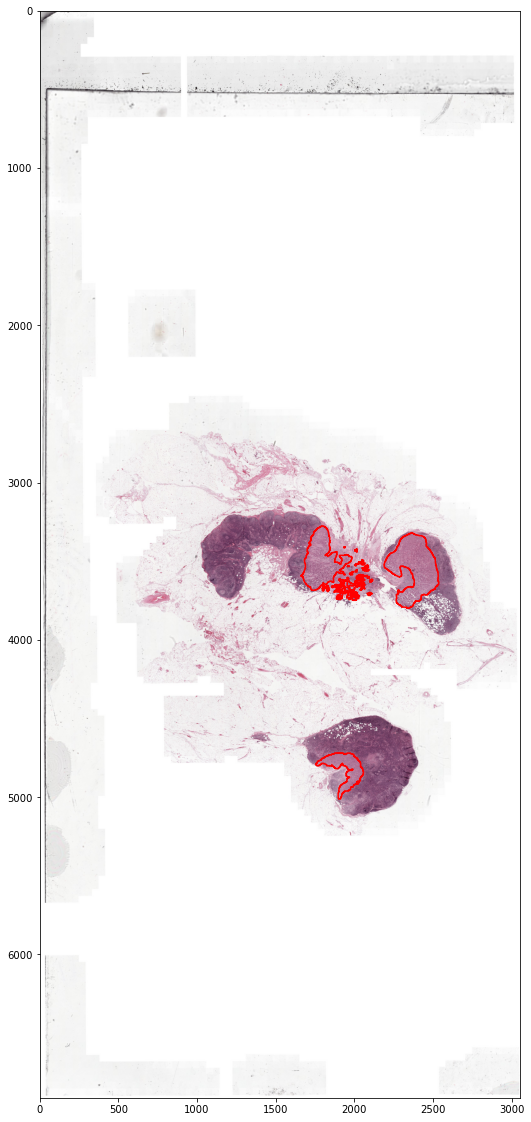

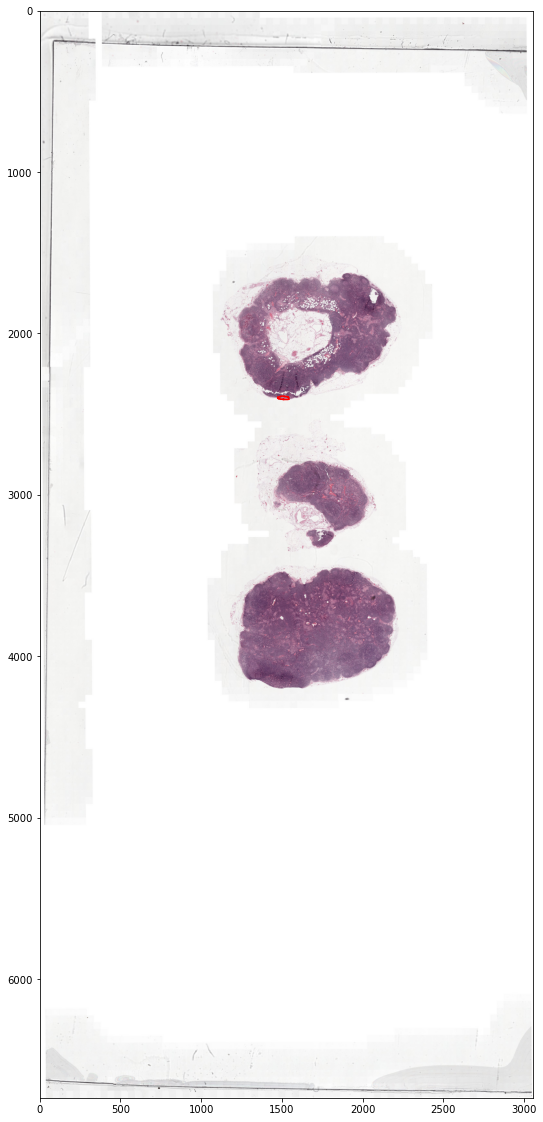

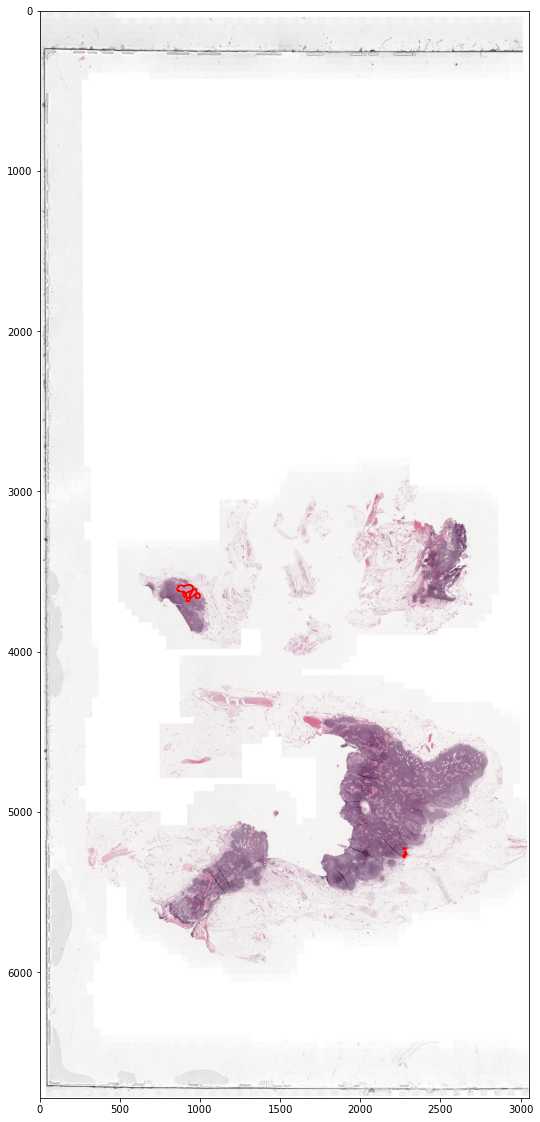

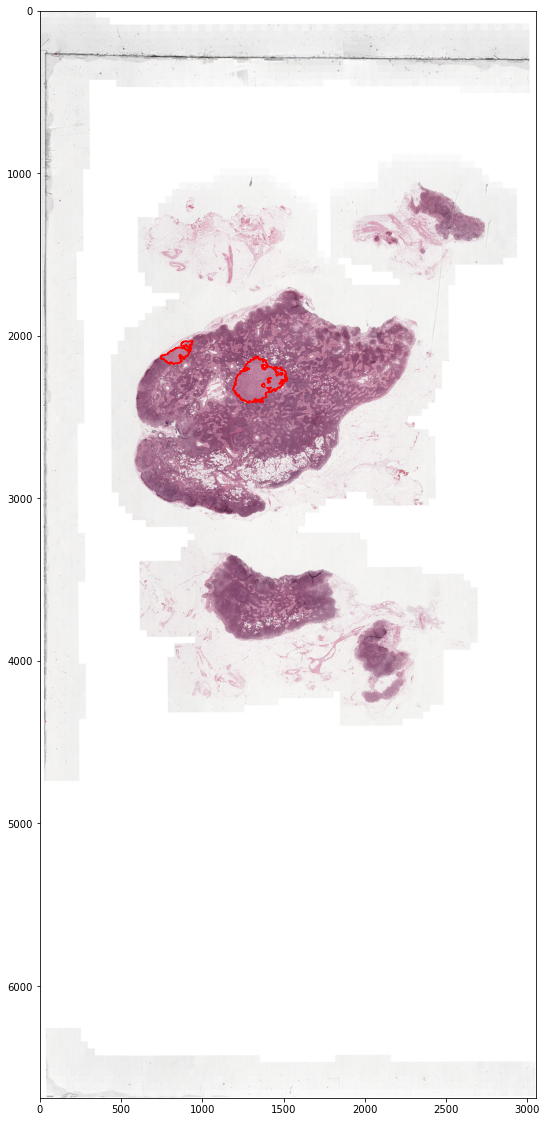

In [4]:
except_list = []

for idx, path in enumerate(tqdm(sorted(tumor_list[:10]))):
    try:
        xml_path = path.replace('tumor/','mask_xml/').replace('.tif','.xml')

        wsi_slide = openslide.OpenSlide(path)
        w_, h_ = wsi_slide.level_dimensions[LEVEL]
        wsi_array = np.array(wsi_slide.read_region([0,0], LEVEL, [w_, h_]))[:,:,:3]
        
        plt.figure(figsize=(20, 20))
        plt.imshow(wsi_array)

        tissue_mask= np.zeros((h_, w_), dtype=np.uint8)
        tree = ET.parse(xml_path)
        root = tree.getroot()
        for root_ in (root.iter('Annotation')):
            for anno_ in (root_.iter('Coordinates')):
                rect_ = []
                for child in anno_.iter("Coordinate"):
                    cooldinates = child.attrib
                    x_ = float(cooldinates.get('X')) // (2**LEVEL)
                    y_ = float(cooldinates.get('Y')) // (2**LEVEL)
                    rect_.append((x_, y_))
                cnt_ = np.array(rect_).reshape((-1, 1, 2)).astype(np.int32)
                cv2.fillPoly(tissue_mask, [cnt_], 255)
                plt.plot(cnt_[..., 0], cnt_[..., 1], color='red')
        
        plt.show()
        
        del wsi_slide, wsi_array, tissue_mask
        gc.collect()
    
    except:
        print(path)
        except_list.append(path)